# Recurrent Neural Networks (RNNs)

 RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. This way they have a “memory” which captures information about what has been calculated so far.

RNNs can be thought of as multiple copies of the same network, each passing a message to a successor.

 ![](https://miro.medium.com/v2/format:webp/1*xLcQd_xeBWHeC6CeYSJ9bA.png)

What is the math behind it?

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SZgYDYddpFvdLDLaS1zZvw.jpeg)

**Disadvantages of RNNs**

- *The* main limitation of vanilla RNNs is that they suffer from the vanishing gradient problem, where gradients diminish as they propagate back through time, making it difficult to learn long-range dependencies.

#Long Short Term Memory networks (LSTMs)

LSTMs are explicitly designed to avoid the long-term dependency problem. They processes sequential data by selectively remembering and forgetting information over time through its gating mechanisms, allowing it to capture long-term dependencies and mitigate the vanishing gradient problem typically encountered in traditional RNNs.

![](https://i.stack.imgur.com/aTDpS.png)

**Disadvantages of LSTMs**

- LSTMs are more complex than traditional RNNs, which can make them more challenging to understand, implement, and train. This complexity can also lead to longer training times and increased computational resources.

#Gated Recurrent Units (GRUs)

GRUs are a type of RNN architecture similar to LSTMs but with a simpler design. Compared to LSTMs, they combine the forget and input gates into a single update gate, and they lack a separate cell state.

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*QFOzE0TEMFERg3G5_5HiPA.png)

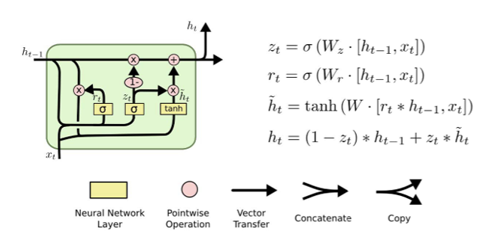

# A practical example on Natural Language Processing (NLP)
In this part we are going to use the above networks to generate different names.

#Download the dataset

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2024-03-14 21:47:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.43, 18.172.170.106, 18.172.170.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2024-03-14 21:47:33 (51.3 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/I

In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

# Load the data

In [ ]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Spanish', 'Czech', 'Italian', 'Irish', 'Arabic', 'German', 'Russian', 'Polish', 'Dutch', 'Scottish', 'Portuguese', 'Japanese', 'Chinese', 'English', 'Korean', 'Vietnamese', 'French', 'Greek']


#Define the RNN


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Define input to hidden layer
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input_size + hidden_size because we concatenate input and hidden state
        # Define input to output layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # Define output to output layer
        self.o2o = nn.Linear(hidden_size + output_size, output_size)  # hidden_size + output_size because we concatenate hidden state and output
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.1)  # 10% dropout probability
        # Softmax layer to convert output into probabilities
        self.softmax = nn.LogSoftmax(dim=1)  # LogSoftmax along the output dimension ( first dimension typically represents the batch size). LogSoftmax --> numerical stability

    def forward(self, input, hidden):
        # Concatenate input and hidden state
        input_combined = torch.cat((input, hidden), 1)
        # Compute hidden state
        hidden = self.i2h(input_combined)
        # Compute output based on input and hidden state
        output = self.i2o(input_combined)
        # Concatenate hidden state and output
        output_combined = torch.cat((hidden, output), 1)
        # Compute final output
        output = self.o2o(output_combined)
        # Apply dropout to the output
        output = self.dropout(output)
        # Apply softmax to convert output into probabilities
        output = self.softmax(output)
        return output, hidden

    # Initialize hidden state with zeros
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


#Define all the fuctions needed for training

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    return torch.zeros(1, n_categories)

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to create a tensor representing the target line (sequence of characters)
def targetTensor(line):
    # Get the indexes of each letter in the line (except for the last one)
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    # Append the index for the end-of-string token
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category, line = randomTrainingPair()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

criterion = nn.NLLLoss() # Negative Log Likelihood Loss because we use nn.LogSoftmax

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    # Expand the dimensions of target_line_tensor to match the shape of output tensor
    target_line_tensor.unsqueeze_(-1)

    # Initialize the hidden state of the RNN
    hidden = rnn.initHidden()

    # Clear the gradients of the model parameters
    rnn.zero_grad()

    # Initialize the loss to zero
    loss = torch.Tensor([0])  # Alternatively, you can simply use loss = 0

    # Iterate over each character in the input line
    for i in range(input_line_tensor.size(0)):
        # Forward pass: Compute the output and update the hidden state
        output, hidden = rnn(input_line_tensor[i], hidden)

        # Compute the loss for this time step using the criterion (usually NLLLoss)
        l = criterion(output, target_line_tensor[i])

        # Accumulate the loss
        loss += l

    # Backpropagate the gradients
    loss.backward()

    # Update the model parameters using gradient descent
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    # Return the final output and the average loss per character in the input line
    return output, loss.item() / input_line_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


#Define the functions needed for generation

In [ ]:
def sample(start_letter='A'):
    # Disable gradient tracking since we're only sampling
    with torch.no_grad():
        # Convert the start letter to a tensor
        input = inputTensor(start_letter)
        # Initialize the hidden state of the RNN
        hidden = rnn.initHidden()

        # Initialize the output name with the start letter
        output_name = start_letter

        # Iterate until maximum length is reached or end-of-sequence token is predicted
        for i in range(max_length):
            # Forward pass: Compute the output and update the hidden state
            output, hidden = rnn(input[0], hidden)
            # Get the index of the top predicted letter
            topv, topi = output.topk(1)
            topi = topi[0][0]
            # If the predicted letter is the end-of-sequence token, break
            if topi == n_letters - 1:
                break
            else:
                # Otherwise, append the predicted letter to the output name
                letter = all_letters[topi]
                output_name += letter
            # Prepare input for the next iteration (use the predicted letter)
            input = inputTensor(letter)

        # Return the generated name
        return output_name

def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

#Train the RNN model

0m 33s (5000 5%) 2.2401
0m 52s (10000 10%) 3.1969
1m 10s (15000 15%) 2.9867
1m 29s (20000 20%) 2.2811
1m 48s (25000 25%) 3.0207
2m 8s (30000 30%) 2.5848
2m 26s (35000 35%) 2.6735
2m 45s (40000 40%) 2.9210
3m 3s (45000 45%) 3.0509
3m 20s (50000 50%) 2.5094
3m 39s (55000 55%) 2.1325
3m 57s (60000 60%) 2.4043
4m 15s (65000 65%) 2.1904
4m 33s (70000 70%) 2.6072
4m 53s (75000 75%) 2.7866
5m 11s (80000 80%) 2.6136
5m 29s (85000 85%) 2.2412
5m 47s (90000 90%) 2.8503
6m 5s (95000 95%) 2.2345
6m 24s (100000 100%) 2.3427


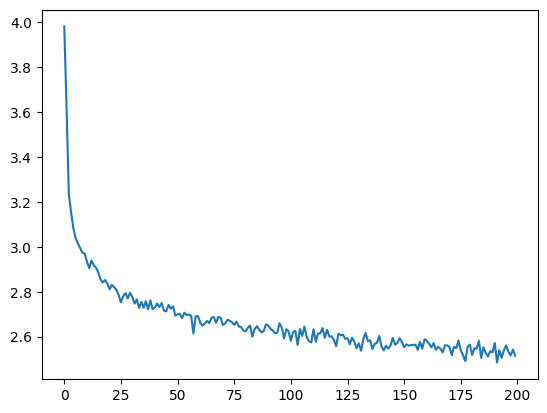

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(input_line_tensor, target_line_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

plt.figure()
plt.plot(all_losses)

#Generate diffent names with RNN

In [ ]:
max_length = 20

samples('ABCDEF')

Allas
Bara
Cari
Dang
Eoro
Faris


#Train with LSTM

0m 42s (5000 5%) 2.8731
1m 26s (10000 10%) 3.1237
2m 8s (15000 15%) 2.7582
2m 51s (20000 20%) 2.3610
3m 34s (25000 25%) 2.8054
4m 17s (30000 30%) 2.6384
4m 59s (35000 35%) 2.5051
5m 42s (40000 40%) 2.8214
6m 25s (45000 45%) 2.7394
7m 7s (50000 50%) 2.4901
7m 50s (55000 55%) 2.4483
8m 33s (60000 60%) 3.0017
9m 14s (65000 65%) 2.5119
9m 56s (70000 70%) 2.5357
10m 38s (75000 75%) 2.9575
11m 21s (80000 80%) 2.6482
12m 5s (85000 85%) 2.5795
12m 47s (90000 90%) 1.9299
13m 30s (95000 95%) 2.6512
14m 13s (100000 100%) 2.0950


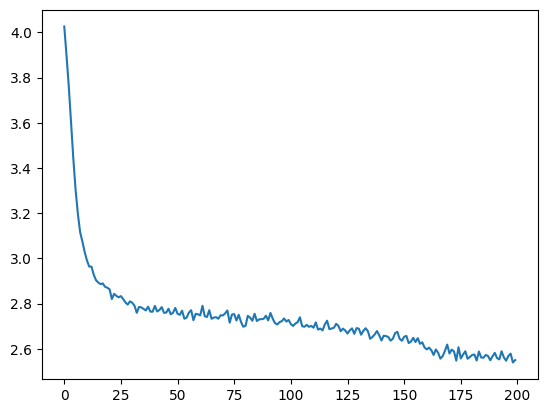

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Input gate: input, previous hidden state, and bias
        self.W_ix = nn.Linear(input_size, hidden_size)
        self.W_ih = nn.Linear(hidden_size, hidden_size)
        self.b_i = nn.Parameter(torch.zeros(1, hidden_size)) # Define a trainable parameter

        # Forget gate: input, previous hidden state, and bias
        self.W_fx = nn.Linear(input_size, hidden_size)
        self.W_fh = nn.Linear(hidden_size, hidden_size)
        self.b_f = nn.Parameter(torch.zeros(1, hidden_size))

        # Output gate: input, previous hidden state, and bias
        self.W_ox = nn.Linear(input_size, hidden_size)
        self.W_oh = nn.Linear(hidden_size, hidden_size)
        self.b_o = nn.Parameter(torch.zeros(1, hidden_size))

        # Cell gate: input, previous hidden state, and bias
        self.W_gx = nn.Linear(input_size, hidden_size)
        self.W_gh = nn.Linear(hidden_size, hidden_size)
        self.b_g = nn.Parameter(torch.zeros(1, hidden_size))

        # Output layer
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        h, c = hidden

        # Input gate
        i = torch.sigmoid(self.W_ix(input) + self.W_ih(h) + self.b_i)

        # Forget gate
        f = torch.sigmoid(self.W_fx(input) + self.W_fh(h) + self.b_f)

        # Output gate
        o = torch.sigmoid(self.W_ox(input) + self.W_oh(h) + self.b_o)

        # Cell gate
        g = torch.tanh(self.W_gx(input) + self.W_gh(h) + self.b_g)

        # Cell state update
        c = f * c + i * g

        # Hidden state update
        h = o * torch.tanh(c)

        # Output prediction
        output = self.linear(h)
        output = self.softmax(output)

        return output, (h, c)

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))


rnn = LSTM(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0  # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(input_line_tensor, target_line_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

plt.figure()
plt.plot(all_losses)

#Generate names with LSTM



In [ ]:
max_length = 20

samples('ABCDEF')

Aan
Ban
Can
Dan
Ean
Fan


# Train with GRU

0m 34s (5000 5%) 3.3142
1m 8s (10000 10%) 2.7802
1m 43s (15000 15%) 2.6679
2m 18s (20000 20%) 2.8079
2m 52s (25000 25%) 3.0400
3m 28s (30000 30%) 2.8419
4m 3s (35000 35%) 2.8447
4m 38s (40000 40%) 2.5523
5m 12s (45000 45%) 2.8922
5m 47s (50000 50%) 2.2931
6m 23s (55000 55%) 2.4354
7m 0s (60000 60%) 3.4713
7m 35s (65000 65%) 2.4498
8m 9s (70000 70%) 2.4965
8m 44s (75000 75%) 3.1165
9m 20s (80000 80%) 2.5348
10m 0s (85000 85%) 2.2373
10m 35s (90000 90%) 2.2972
11m 10s (95000 95%) 2.2472
11m 44s (100000 100%) 2.6147


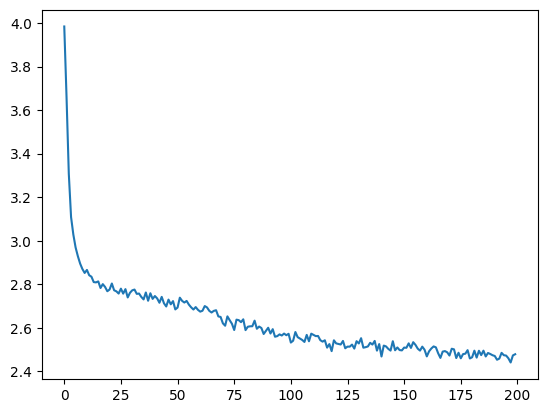

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # Update gate: input, previous hidden state, and bias
        self.W_zx = nn.Linear(input_size, hidden_size)
        self.W_zh = nn.Linear(hidden_size, hidden_size)
        self.b_z = nn.Parameter(torch.zeros(1, hidden_size))

        # Reset gate: input, previous hidden state, and bias
        self.W_rx = nn.Linear(input_size, hidden_size)
        self.W_rh = nn.Linear(hidden_size, hidden_size)
        self.b_r = nn.Parameter(torch.zeros(1, hidden_size))

        # Hidden state: input, previous hidden state, and bias
        self.W_hx = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.b_h = nn.Parameter(torch.zeros(1, hidden_size))

        # Output layer
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        h = hidden

        # Update gate
        z = torch.sigmoid(self.W_zx(input) + self.W_zh(h) + self.b_z)

        # Reset gate
        r = torch.sigmoid(self.W_rx(input) + self.W_rh(h) + self.b_r)

        # Hidden state
        h_tilde = torch.tanh(self.W_hx(input) + self.W_hh(r * h) + self.b_h)

        # New hidden state
        h = (1 - z) * h + z * h_tilde

        # Output prediction
        output = self.linear(h)
        output = self.softmax(output)

        return output, h

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

rnn = GRU(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(input_line_tensor, target_line_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

plt.figure()
plt.plot(all_losses)

#Generate names with GRU

In [ ]:
max_length = 20

samples('ABCDEF')

Aran
Ban
Can
Dang
Ean
Fang
